# HSE 2021: Mathematical Methods for Data Analysis

## Homework 4

**Warning 1**: You have 2 weeks for this assignemnt.  **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells


### Contents

#### Decision Trees - 7 points
* [Task 1](#task1) (0.5 points)
* [Task 2](#task2) (0.5 points)
* [Task 3](#task3) (2 points)
* [Task 4](#task4) (0.5 points)
* [Task 5](#task5) (0.5 points)
* [Task 6](#task6) (2 points)
* [Task 7](#task7) (0.5 points)
* [Task 8](#task8) (0.5 points)

#### Ensembles - 3 points
* [Task 1](#task2_1) (1 point)
* [Task 2](#task2_2) (0.7 points)
* [Task 3](#task2_3) (0.5 points)
* [Task 4](#task2_4) (0.7 points)
* [Task 5](#task2_5) (0.1 points)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['figure.figsize'] = (11, 5)
%matplotlib inline

# Part 1. Decision Tree Regressor

In this task you will be implementing decision tree for the regression by hand. 

### Task 1 <a id="task1"></a> (0.5 points)

Here you should implement the function `H()` which calculates impurity criterion. We will be training regression tree, and will take mean absolute deviation as impurity criterion.

* You cannot use loops
* If `y` is empty, the function should return 0

In [2]:
def H(y):
    """
    Calculate impurity criterion
    
    Parameters
    ----------
    y : np.array
        array of objects target values in the node

    Returns
    -------
    H(R) : float
        Impurity in the node (measuread by variance)
    """
    if len(y) == 0:
        return 0
    return np.mean(np.abs(y - np.mean(y)))

In [3]:
# Test the function
assert np.allclose(H(np.array([4, 2, 2, 2])), 0.75)
assert np.allclose(H(np.array([])), 0.0)

### Task 2 <a id="task2"></a>  (0.5 points)

To find the best split in the node we need to calculate the cost function. Denote: 
- `R` all the object in the node
- `j` index of the feature selected for the split
- `t` threshold
- `R_l` and `R_r` objects in the left and right child nodes correspondingly

We get the following cost function:

$$
Q(R, j, t) =\frac{|R_\ell|}{|R|}H(R_\ell) + \frac{|R_r|}{|R|}H(R_r) \to \min_{j, t},
$$

Implement the function `Q`, which should calculate value of the cost function for a given feature and threshold.

In [4]:
def Q(X, y, j, t):
    """
    Calculate cost function
    Parameters
    ----------
    X : ndarray
        array of objects in the node 
    y : ndarray
        array of target values in the node 
    j : int
        feature index (column in X)
    t : float
        threshold

    Returns
    -------
    Q : float
        Value of the cost function
    """   
    bounds = X[:,j] < t
    left = y[bounds]
    right = y[~bounds]
    size = X.shape[0]
    Q = (H(left) * left.size + H(right) * right.size) / size
    return Q

### Task 3 <a id="task3"></a>  (2 points)

Now, let's implement `MyDecisionTreeRegressor` class. More specifically, you need to implement the following methods:

- `best_split`
- `grow_tree`
- `get_prediction`

Also, please add `min_samples_leaf` parameter to your class

Read docstrings for more details. Do not forget to use function `Q` implemented above, when finding the `best_split`

In [5]:
class Node(object):
    """
    Class for a decision tree node.
    
    Parameters
    ----------
    right : Node() or None
        Right child
    right : Node() or None
        Left child
    threshold: float
        
    column: int
        
    depth: int
        
    prediction: float
        prediction of the target value in the node 
        (average values calculated on a train dataset)
    is_terminal:bool
        indicates whether it is a terminal node (leaf) or not
    """    
    def __init__(self):        
        self.right = None
        self.left = None
        self.threshold = None
        self.column = None
        self.depth = None
        self.is_terminal = False
        self.prediction = None
        
    def __repr__(self):
        if self.is_terminal:
            node_desc = 'Pred: {:.2f}'.format(self.prediction)
        else:
            node_desc = 'Col {}, t {:.2f}, Pred: {:.2f}'. \
            format(self.column, self.threshold, self.prediction)
        return node_desc

In [6]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class MyDecisionTreeRegressor(RegressorMixin, BaseEstimator):
    """
    Class for a Decision Tree Regressor.

    Parameters
    ----------
    max_depth : int
        Max depth of a decision tree.
    min_samples_split : int
        Minimal number of samples (objects) in a node to make a split.
    """ 
    def __init__(self, max_depth=3, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
            
    def best_split(self, X, y):
        """
        Find the best split in terms of Q of data in a given decision tree node. 
        Try all features and thresholds. 
        
        Parameters
        ----------
        X : ndarray, shape (n_objects, n_features)
            Objects in the parent node
        y : ndarray, shape (n_objects, )
            1D array with the object labels. 
            
        Returns
        -------
        best_split_column : int
            Index of the best split column
        best_threshold : float
            The best split condition.
        X_left : ndarray, shape (n_objects_l, n_features)
            Objects in the left child
        y_left : ndarray, shape (n_objects_l, )
            Objects labels in the left child. 
        X_right : ndarray, shape (n_objects_r, n_features)
            Objects in the right child
        y_right : ndarray, shape (n_objects_r, )
            Objects labels in the right child. 
        """
        
        # To store best split parameters
        best_split_column = None
        best_threshold = None
        # without splitting
        best_cost = H(y) 
        
        for c in range(X.shape[1]):
            column = X[:,c]
            for threshold in column:
                cost = Q(X, y, c, threshold)
                if cost < best_cost:
                    best_cost = cost
                    best_split_column = c
                    best_threshold = threshold
        if best_split_column == None:
            return None, None, None, None, None, None
        bounds = X[:, best_split_column] < best_threshold
        X_left = X[bounds, :]
        y_left = y[bounds]
        X_right = X[~bounds, :]
        y_right = y[~bounds]
        return best_split_column, best_threshold, X_left, y_left, X_right, y_right
    
    def is_terminal(self, node, y):
        """
        Check terminality conditions based on `max_depth`, 
        `min_samples_split` parameters for a given node. 
        
        Parameters
        ----------
        node : Node, 
            
        y : ndarray, shape (n_objects, )
            Object labels. 
            
        Returns
        -------
        Is_termial : bool
            If True, node is terminal
        """
        if node.depth >= self.max_depth:    
            return True
        if len(y) < self.min_samples_split:   
            return True
        return False
        
    def grow_tree(self, node, X, y):
        """
        Reccurently grow the tree from the `node` using a `X` and `y` as a dataset:
         - check terminality conditions
         - find best split if node is not terminal
         - add child nodes to the node
         - call the function recursively for the added child nodes
        
        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        X : ndarray, shape (n_objects, n_features)
            Objects 
        y : ndarray, shape (n_objects)
            Labels
        """
        
        if self.is_terminal(node, y):
            node.is_terminal =True
            return
                
        best_split_column, best_threshold, X_left, y_left, X_right, y_right = self.best_split(X, y)
        if best_split_column == None:
            node.is_terminal = True
            return
        node.column = best_split_column
        node.threshold = best_threshold
        new_depth = node.depth + 1
        node.left = Node()
        node.right = Node()
        node.left.depth = new_depth
        node.right.depth = new_depth
        node.left.prediction = np.mean(y_left)
        node.right.prediction = np.mean(y_right)
        self.grow_tree(node.left, X_left, y_left)
        self.grow_tree(node.right, X_right, y_right)

    def fit(self, X, y):
        """
        Fit the Decision Tree Regressor.
            
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        y : ndarray, shape (n_samples,) or (n_samples, n_outputs)
            The target values.
        Returns
        -------
        self : object
            Returns self.
        """
        X, y = check_X_y(X, y, accept_sparse=False)
        self.is_fitted_ = True
        self.n_features_in_ = X.shape[1]
        
        # Initialize the tree (root node)
        self.tree_ = Node()                             
        self.tree_.depth = 1                            
        self.tree_.prediction = np.mean(y)
        
        # Grow the tree
        self.grow_tree(self.tree_, X, y)
        return self        
    
    def get_prediction(self, node, x):
        """
        Get prediction for an object `x`
            - Return prediction of the `node` if it is terminal
            - Otherwise, recursively call the function to get 
            predictions of the proper child
        
        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        x : ndarray, shape (n_features,)
            Array of feature values of one object.
        Returns
        -------
        y_pred : float
            Prediction for an object x
        """
        if node.is_terminal:
            return node.prediction

        if x[node.column] < node.threshold:
            return self.get_prediction(node.left, x)
        y_pred = self.get_prediction(node.right, x)
        return y_pred
    
    def predict(self, X):
        """ 
        Get prediction for each object in X
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            Returns predictions.
        """
        # Check input and that `fit` had been called
        X = check_array(X, accept_sparse=False)
        check_is_fitted(self, 'is_fitted_')
        
        # Get predictions
        y_predicted = []
        for x in X:
            y_curr = self.get_prediction(self.tree_, x)
            y_predicted.append(y_curr)
        return np.array(y_predicted)

In [7]:
# check yourself
from sklearn.utils.estimator_checks import check_estimator

check_estimator(MyDecisionTreeRegressor())

### Task 4 <a id="task4"></a>  (0.5 points)

Load boston dataset and split it on the train ($75\%$) and test ($25\%$). Fit Decision Tree of **depth 1, 3, 5** and make the following plots for every case:

- Scatter plot of the traning points (selected for split feature on the x-axis, target variable on the y-axis)
- Fitted model (tree visualization)

Compare `MAE` on train and test. Have trees overfitted?

In [8]:
import pickle

data = pickle.load(open('boston.pkl', 'rb'))
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

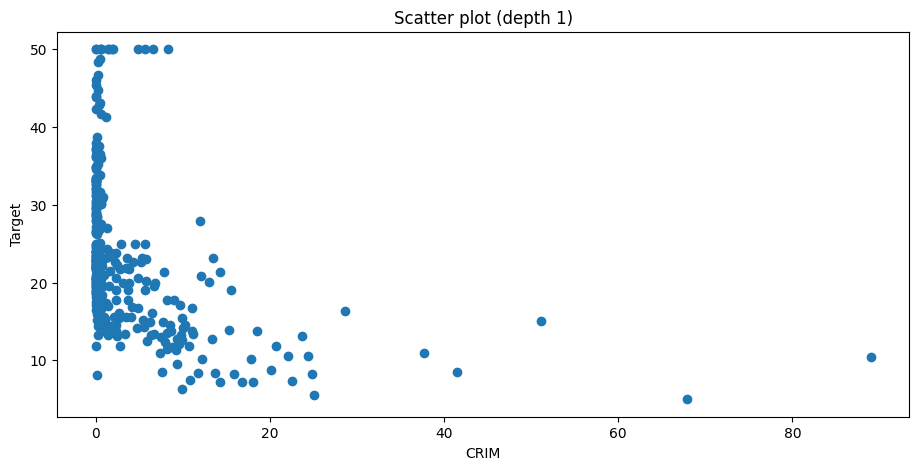

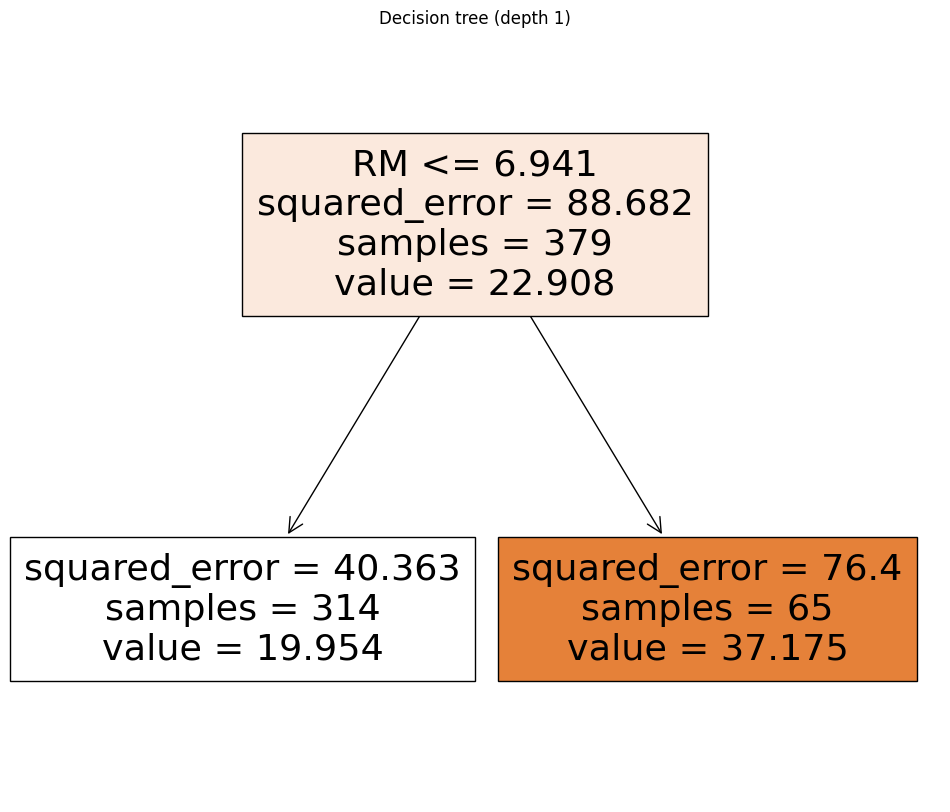

Train MAE (depth 1): 5.087905121784422
Test MAE (depth 1): 4.865877696204193


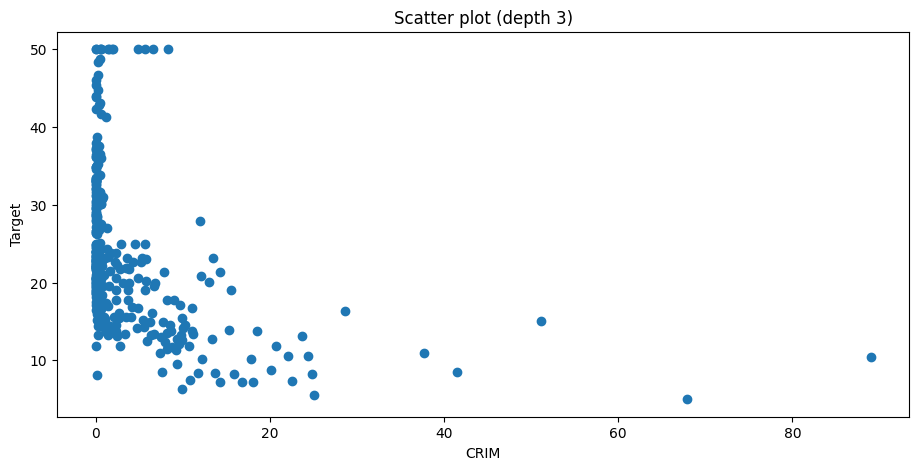

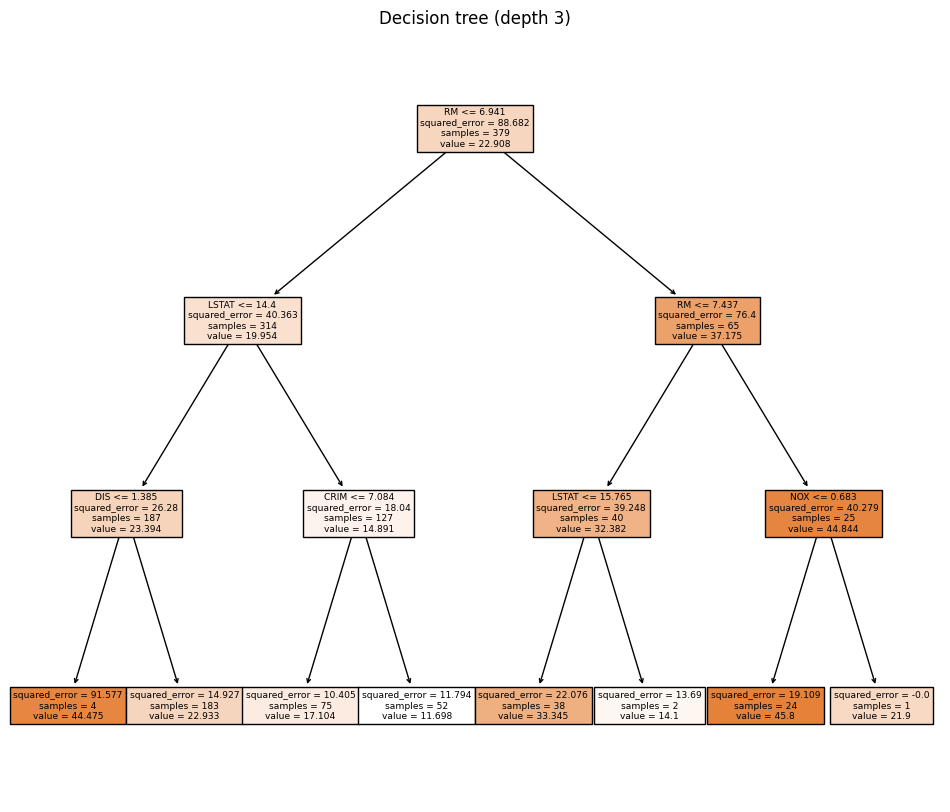

Train MAE (depth 3): 2.963004849928893
Test MAE (depth 3): 3.219597908867949


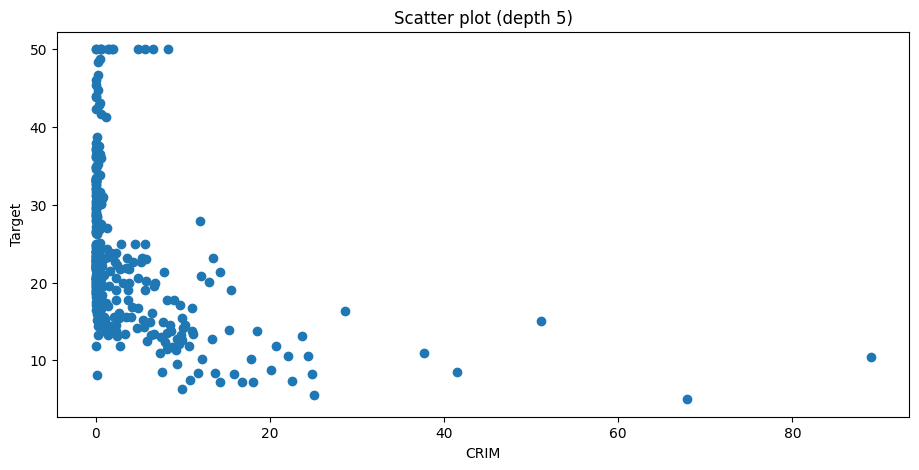

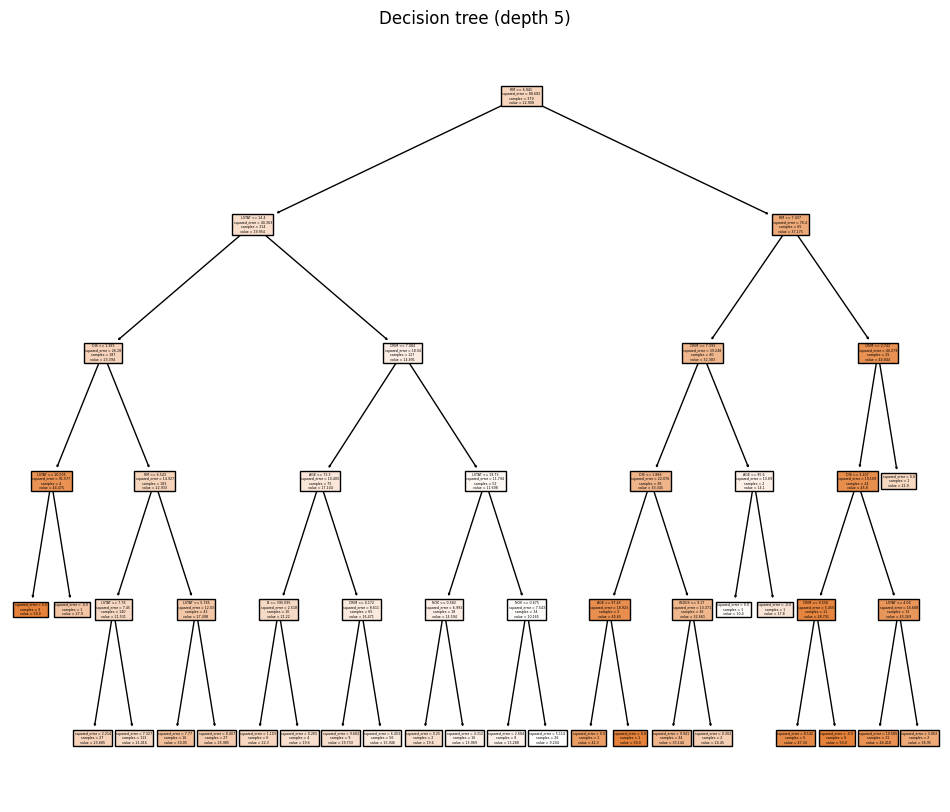

Train MAE (depth 5): 1.8894049606209131
Test MAE (depth 5): 2.348644934888596


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn import tree

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

depths = [1, 3, 5]
for depth in depths:
    model = DecisionTreeRegressor(max_depth=depth)
    model.fit(X_train, y_train)
    
    # Scatter plot of training points
    plt.scatter(X_train.iloc[:, 0], y_train, label='Training')
    plt.xlabel(X.columns[0])
    plt.ylabel('Target')
    plt.title(f'Scatter plot (depth {depth})')
    plt.show()
    
    # Fitted model (tree visualization)
    plt.figure(figsize=(12, 10))
    tree.plot_tree(model,filled=True,feature_names=X.columns)
    plt.title(f'Decision tree (depth {depth})')
    plt.show()
    
    # Comparing MAE
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    tr_mae = mean_absolute_error(y_train, train_pred)
    test_mae = mean_absolute_error(y_test, test_pred)
    print(f"Train MAE (depth {depth}): {tr_mae}")
    print(f"Test MAE (depth {depth}): {test_mae}")

As the depth increases, the train MAE decreases, while the test MAE first goes up and then goes down. So the trees with the bigger depth (starting from depth=5) show signs of overfitting the train data.
The trees with depth=3 show the best performance out of the given three, as they capture complexity and do not overfit. 

### Task 5 <a id="task5"></a>  (0.5 points)

Keep working with boston dataset. 
- Use `GridSearchCV` to find the best hyperparameters among [`max_depth`, `min_samples_leaf`] on 5-Fold cross-validation
- Train the model with the best set of hyperparameters on the whole train dataset. 
- Report `MAE` on test dataset and hyperparameters of the best estimator. 

In [10]:
from sklearn.model_selection import GridSearchCV

# Parameters (max_depth and min_samples_leaf)
param_grid = {'max_depth': [1, 3, 5, 7, 9], 'min_samples_leaf': [1, 2, 3, 4, 5]}

tree = MyDecisionTreeRegressor()
grids = GridSearchCV(tree, param_grid, cv=5, scoring='neg_mean_absolute_error')
grids.fit(X_train, y_train)
best_tree = grids.best_estimator_ # finding best estimator
y_pred_test = best_tree.predict(X_test) # predictions on test set
mae_test_best = mean_absolute_error(y_test, y_pred_test)

# Conclusions
print("Best hyperparams:", grids.best_params_)
print("MAE for test dataset:", mae_test_best)


Best hyperparams: {'max_depth': 7, 'min_samples_leaf': 1}
MAE for test dataset: 3.0862098309254242


### Task 6 <a id="task6"></a>  (2 points)

Recall definition of bias and variance:
$$
\text{Bias}^2 = \mathbb{E}_{p(x, y)} \left[  (f(x) - \mathbb{E}_{\mathbb{X}}a_{\mathbb{X}}(x))^2 \right] \\
\text{Variance} = \mathbb{E}_{p(x, y)} \left[  \mathbb{V}_{\mathbb{X}}( a_{\mathbb{X}}(x))  \right]
$$

We wil now use the following algorithm to estimate bias and variance:

1. Use bootsrap to create `n_iter` samples from the original dataset: $X_1, \dots, X_{n_iter}$
2. For each bootstrapped sample define out-of-bag (OOB) sample $Z_1, \dots, Z_{n_iter}$, which contain all the observations, which did not appear in the corresponding boostraped sample
3. Fit the model on $X_i$s and compute predictions on $Z_i$s
4. For a given *object* $n$:
     - bias^2: squared difference between true value $y_n$ and average prediction (average over the algorithms, for which $n$ was in OOB)
     - variance: variance of the prediction (predictions of the algorithms, for which $n$ was in OOB)
5. Average bias^2 and variance over all the points
    
**Implement `get_bias_variance` function, using the algorithm above**

*Note:*  You can only use 1 loop (for bootsrap iterations). All other operations should be vectorized. 

In [11]:
import warnings

warnings.filterwarnings('ignore')

In [12]:
def get_bias_variance(estimator, x, y, n_iter):
    """ 
    Calculate bias and variance of the `estimator`. 
    Using a given dataset and bootstrap with `n_iter` samples. 

    Parameters
    ----------
    x : ndarray, shape (n_samples, n_features)
        The input samples.
    y : ndarray, shape (n_samples, n_features)
        The input samples.
    n_iter: int
        Number of samples in 
    Returns
    -------
    bias2 : float, 
        Estiamted squared bias
    variance : float, 
        Estiamted variance
    """
    size = x.shape[0]
    predictions = np.full((size, n_iter), np.nan)
    for index in range(n_iter):
        i = np.random.choice(size, size)
        arr = np.ones(size, dtype=bool)
        arr[i] = False
        estimator.fit(x[i, :], y[i])
        pred = estimator.predict(x[arr, :])
        predictions[arr, index] = pred
    bias2 = np.nanmean((np.nanmean(predictions,axis=1)-y_train)**2)
    variance = np.nanmean(np.nanvar(predictions,axis=1))
    return bias2, variance


In [13]:
# Test
estimator = MyDecisionTreeRegressor(max_depth=8, min_samples_split=15)

get_bias_variance(estimator, X_train.values, y_train, 10)

(20.435443494781524, 7.655902109059462)

### Task 7 <a id="task7"></a>  (0.5 points)

Compute bias and variance for the trees with different min_samples_split. Plot how bias and variance change as min_samples_split increases. 

Comment on what you observe, how does your result correspond to theory?

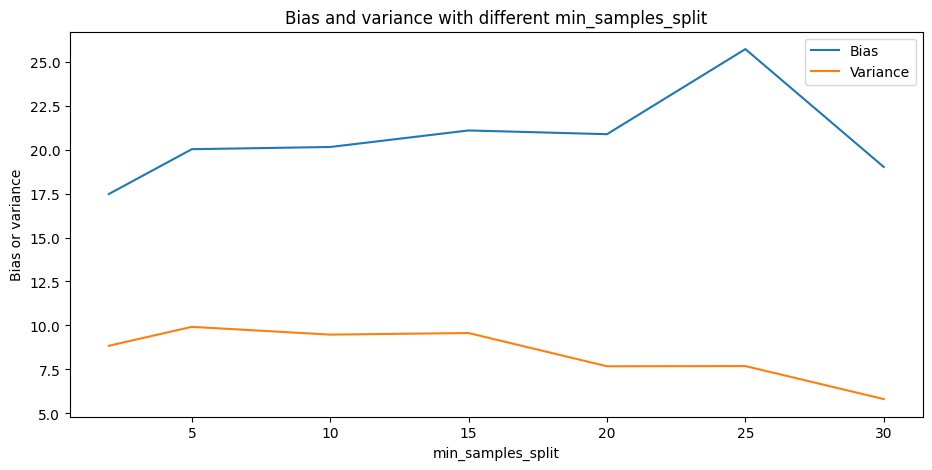

In [14]:
import matplotlib.pyplot as plt

min_samples_splits = [2, 5, 10, 15, 20, 25, 30]
biases = []
variances = []

for split in min_samples_splits:
    estimator = MyDecisionTreeRegressor(max_depth=8, min_samples_split=split)
    bias, variance = get_bias_variance(estimator, X_train.values, y_train, 10)
    biases.append(bias)
    variances.append(variance)

plt.plot(min_samples_splits, biases, label='Bias')
plt.plot(min_samples_splits, variances, label='Variance')
plt.xlabel('min_samples_split')
plt.ylabel('Bias or variance')
plt.title('Bias and variance with different min_samples_split')
plt.show()


As min_samples_split increases, the bias should increase whereas variance should decrease. This is because a larger min_samples_split value leads to simpler trees and fewer splits, which can end up with bigger bias but smaller variance.

As we can see, the bias increases at first, because decision tree can capture more complex patterns with smaller min_samples_split. Nevertheless, as min_samples_split continues to increase, the bias starts to decrease (since the model becomes simpler). And the variance steadily decreases.

### Task 8 <a id="task8"></a>  (0.5 points)

Let's try to reduce variance with bagging. Use `sklearn.ensemble.BaggingRegressor` to get an ensemble and compute its bias and variance. 

Answer the following questions:
 - How bagging should affect bias and variance in theory?
 - How bias and variance change (if they change) compared to an individual tree in you experiments? 
 - Do your results align with the theory? Why?

In [15]:
from sklearn.ensemble import BaggingRegressor

bag = BaggingRegressor(MyDecisionTreeRegressor(8), random_state=42)
bias, var = get_bias_variance(bag, X_train.values, y_train, 10)
print(bias, var)

16.613305616078126 2.570811331175701


Theoretically speaking, bagging should reduce variance while not changing the bias too much (as bagging involves creating several models and combining their predictions, which helps with smoothing out the predictions of initial model).

Here bias changed from 20.435443494781524 to 16.613305616078126, variance changed from 7.655902109059462 to 2.570811331175701, so the result quite align with the theory. So the bagging technique has effectively reduced the variance without significantly impacting the bias, as expected.

# Part 2. More Ensembles

In this part we will be working with [Billionaires Statistics Dataset](https://www.kaggle.com/datasets/nelgiriyewithana/billionaires-statistics-dataset) to solve a classification task. 

In [16]:
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('Billionaires Statistics Dataset.csv')

le = LabelEncoder()
y = le.fit_transform(df['selfMade'])
X = df.drop('selfMade', axis=1)
X.head(5)

,rank,finalWorth,category,personName,age,country,city,source,industries,countryOfCitizenship,...,cpi_change_country,gdp_country,gross_tertiary_education_enrollment,gross_primary_education_enrollment_country,life_expectancy_country,tax_revenue_country_country,total_tax_rate_country,population_country,latitude_country,longitude_country
0,1,211000,Fashion & Retail,Bernard Arnault & family,74.0,France,Paris,LVMH,Fashion & Retail,France,...,1.1,"$2,715,518,274,227",65.6,102.5,82.5,24.2,60.7,67059887.0,46.227638,2.213749
1,2,180000,Automotive,Elon Musk,51.0,United States,Austin,"Tesla, SpaceX",Automotive,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891
2,3,114000,Technology,Jeff Bezos,59.0,United States,Medina,Amazon,Technology,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891
3,4,107000,Technology,Larry Ellison,78.0,United States,Lanai,Oracle,Technology,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891
4,5,106000,Finance & Investments,Warren Buffett,92.0,United States,Omaha,Berkshire Hathaway,Finance & Investments,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891


### Task 1 <a id="task2_1"></a> (1 point)

Let's start with data preprocessing. 

0. Drop columns, which are not usefull (e.g. a lot of missing values). Motivate your choice. 
1. Split dataset into train and test
2. You've probably noticed that we have both categorical and numerical columns. Here is what you need to do with them:
    - Categorical: Fill missing values and apply one-hot-encoding (if there are many unique values in a column, you can group them by meaning)
    - Numeric: Fill missing values
    
Use `ColumnTranformer` to define a single transformer for all the columns in the dataset. It takes as input a list of tuples

```
ColumnTransformer([
    ('name1', transform1, column_names1),
    ('name2', transform2, column_names2)
])
```

Pay attention to an argument `remainder='passthrough'`. [Here](https://scikit-learn.org/stable/modules/compose.html#column-transformer) you can find some examples of how to use column transformer. 
    
Since we want to apply 2 transformations to categorical feature, it is very convenient to combine them into a `Pipeline`:

```
double_tranform = make_pipeline(
                        transform_1,
                        transform_2
                        )
```

P.S. Choose your favourite way to fill missing values. 

*Hint* Categorical column usually have `dtype = 'object'`. This may help to obtain list of categorical and numerical columns on the dataset. 

In [17]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Let's print columns which have more than 1000 NaN
counter = X.isna().sum(axis=0)
names = list(counter[counter > 1000].index)
print("Columns with many NaN: ", names)

Columns with many NaN:  ['organization', 'title', 'state', 'residenceStateRegion']


In [18]:
# Drop columns with many NaN
df = X.drop(['organization', 'title', 'state', 'residenceStateRegion'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Finding categorical and numeric columns
categorical_cols = [col for col in X.columns if X[col].dtype == 'object']
numeric_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]

# Define column transformer
column_transformer = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numeric_cols),
        ('cat', make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore')), categorical_cols)], 
    remainder='passthrough')

# Transform the data
X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)

### Task 2 <a id="task2_2"></a> (0.7 points)

Fit and compare 5 different models (use sklearn): Gradient Boosting, Random Forest, Decision Tree, SVM, Logitics Regression
    
* Choose one classification metric and justify your choice .
* Compare the models using score on cross validation. Mind the class balance when choosing the cross validation. (You can read more about different CV strategies [here](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold))
* Which model has the best performance? Which models overfit or underfit?

In [19]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, accuracy_score

models = {
    'Gradient Boosting': GradientBoostingClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(),
    'Logistics Regression': LogisticRegression()
}

# Comparing models (with accuracy)
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{name}: accuracy (train) is {scores.mean():.4f}")
    scores2 = cross_val_score(model, X_test, y_test, cv=5, scoring='accuracy')
    print(f"{name}: accuracy (test) is {scores2.mean():.4f}")

Gradient Boosting: accuracy (train) is 0.7921
Gradient Boosting: accuracy (test) is 0.7746
Random Forest: accuracy (train) is 0.8097
Random Forest: accuracy (test) is 0.8030
Decision Tree: accuracy (train) is 0.7675
Decision Tree: accuracy (test) is 0.7350
SVM: accuracy (train) is 0.6866
SVM: accuracy (test) is 0.6856
Logistics Regression: accuracy (train) is 0.6866
Logistics Regression: accuracy (test) is 0.6856


I chose accuracy as a classification metric because it gives information on the overall performance of the model (it illustartes correct predictions). Highest accuracy = best performance. 

Based on accuracy we can see if the model is overfitting or underfitting. If a model has high accuracy on the training set but low accuracy on the test set, it may be overfitting. If a model has low accuracy with both the train and test sets, it may be underfitting.

Here, Random Forest shows the best performance (acc=0.81). SVM and LogisticRegression may be underfitting (acc is around 0.68). GradientBoosting and DecisionTree lean more towards overfitting (out of the given 5), as they show the biggest difference in train accuracy and test accuracy (difference is around 0.02).

### Task 3 <a id="task2_3"></a> (0.5 points)

More Gradient Boosting. You will have to take one of the three popular boosting implementations (xgboost, lightgbm, catboost). Select hyperparameters (number of trees, learning rate, depth) on cross-validation and compare with the methods from the previous task. 

In [24]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

# I have chosen to take xgboost
xgb = XGBClassifier()
params = {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}
xgb_grid = GridSearchCV(xgb, params, cv=5)
xgb_grid.fit(X_train, y_train)
xgb_best = xgb_grid.best_estimator_
xgb_pred = xgb_best.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_pred)
print("XGBoost accuracy: ", xgb_accuracy)

XGBoost accuracy:  0.8181818181818182


As we can see, xgboost shows a higher accuracy than all the methods from the previous task. This is why it is a popular boosting implementation)

### Task 4 <a id="task2_4"></a> (0.7 points)

Now let's train more fancy ensembles:

* Bagging with decision trees as base estimators
* Bagging with gradient boosting (with large amount of trees, >100) as base estimators
* [Voting classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier) 
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Logistic Regression as a final model
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Gradeint Boosting as a final model


If not stated in the task, feel free to tune / choose hyperparameters and base models.

Answer the questions:
* Which model has the best performance?
* Does bagging reduce overfiting of the gradient boosting with large amount of trees? 
* What is the difference between voting and staking? 

In [21]:
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Bagging with decision trees as base estimators
bagging_dt = BaggingClassifier(estimator=DecisionTreeClassifier())
bagging_dt.fit(X_train, y_train)
bagging_dt_pred = bagging_dt.predict(X_test)
bagging_dt_accuracy = accuracy_score(y_test, bagging_dt_pred)

# Bagging with gradient boosting (with large amount of trees) as base estimators
bagging_gb = BaggingClassifier(GradientBoostingClassifier(n_estimators=105))
bagging_gb.fit(X_train, y_train)
bagging_gb_pred = bagging_gb.predict(X_test)
bagging_gb_accuracy = accuracy_score(y_test, bagging_gb_pred)


In [22]:
gr = GradientBoostingClassifier()
rf = RandomForestClassifier()
dtc = DecisionTreeClassifier()
svc = SVC()
lr = LogisticRegression()

estimators_for_voting = [
    ('Gradient Boosting', gr),
    ('Random Forest', rf),
    ('Decision Tree', dtc),
    ('SVM', svc),
    ('Logistics Regression', lr)
]

# Voting classifier
voting_clf = VotingClassifier(estimators=estimators_for_voting)
voting_clf.fit(X_train, y_train)
voting_pred = voting_clf.predict(X_test)
voting_accuracy = accuracy_score(y_test, voting_pred)

# Stacking Classifier with Logistic Regression as a final model
stacking_lr = StackingClassifier(estimators=estimators_for_voting, final_estimator=LogisticRegression())
stacking_lr.fit(X_train, y_train)
stacking_lr_pred = stacking_lr.predict(X_test)
stacking_lr_accuracy = accuracy_score(y_test, stacking_lr_pred)

# Stacking Classifier with Gradient Boosting as a final model
stacking_gb = StackingClassifier(estimators=estimators_for_voting, final_estimator=GradientBoostingClassifier())
stacking_gb.fit(X_train, y_train)
stacking_gb_pred = stacking_gb.predict(X_test)
stacking_gb_accuracy = accuracy_score(y_test, stacking_gb_pred)

# Comparing the accuracies
print("Bagging with Decision Trees Accuracy: ", bagging_dt_accuracy)
print("Bagging with Gradient Boosting Accuracy: ", bagging_gb_accuracy)
print("Voting Classifier Accuracy: ", voting_accuracy)
print("Stacking Classifier with Logistic Regression Accuracy: ", stacking_lr_accuracy)
print("Stacking Classifier with Gradient Boosting Accuracy: ", stacking_gb_accuracy)

Bagging with Decision Trees Accuracy:  0.7935606060606061
Bagging with Gradient Boosting Accuracy:  0.8106060606060606
Voting Classifier Accuracy:  0.8068181818181818
Stacking Classifier with Logistic Regression Accuracy:  0.8371212121212122
Stacking Classifier with Gradient Boosting Accuracy:  0.8371212121212122


Answers:
* The model with the best performance is the one with the highest accuracy. So the best performance is that of Stacking Classifier with Logistic Regression Accuracy and Stacking Classifier with Gradient Boosting Accuracy.
* Bagging with a large number of trees in gradient boosting can help reduce overfitting by creating several subsets of the train data and training each subset with different trees. This helps reduce the variance and overfit of the model.
* The difference between voting and stacking is that in voting several models are trained independently and their predictions are combined with majority or average, while in stacking the predictions of multiple models are used as input to a final model which learns how to best combine these predictions. Stacking also often involves training an additional meta-model, unlike voting.

### Task 5 <a id="task2_5"></a> (0.1 points)

Report the test score for the best model, that you were able to train. 

The best accuracy is 0.8371212121212122 (by using Stacking Classifier with Logistic Regression Accuracy or Stacking Classifier with Gradient Boosting Accuracy)